## Table of contents:
* [Libraries, functions, constants](#first-bullet)
* [Peak at data](#second-bullet)
* [Commissions](#third-bullet)
    * [Plot](#third-bullet-plot)
    * [Sharpe](#third-bullet-sharpe)
* [Price and position size analysis](#fourth-bullet)
    * [Bins](#fourth-bullet-bins)
    * [Plot](#fourth-bullet-plot)
    * [Sharpe](#fourth-bullet-sharpe)
* [Imbalance delta analysis](#fifth-bullet)
    * [Bins](#fifth-bullet-bins)
    * [Plot](#fifth-bullet-plot)
    * [Sharpe](#fifth-bullet-sharpe)
* [Close status analysis](#sixth-bullet)
    * [Plot](#sixth-bullet-plot)
    * [Sharpe](#sixth-bullet-sharpe)
* [MAE/MFE](#seventh-bullet)
    * [Plot](#seventh-bullet-plot)
    * [Stop loss](#seventh-bullet-sl)
* [MOC print imapct ](#eigth-bullet)
* [Seasonality analysis](#nineth-bullet)
    * [Bins](#nineth-bullet-bins)
    * [Plot](#nineth-bullet-plot)
    * [Sharpe](#nineth-bullet-sharpe)
* [Finally](#tenth-bullet)
    * [Ratios](#tenth-bullet-ratios)
    * [Plot](#tenth-bullet-plot)

## Libraries, functions, constants <a class="anchor" id="first-bullet"></a> 

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 3]

In [181]:
def plot_scatter(stat, ax, xcolumn, ycolumn):    
    ax.scatter(stat[xcolumn].values, stat[ycolumn].values)
    ax.plot(stat[xcolumn], linear_regression(stat, xcolumn, ycolumn), color='red')

    ax.set_xlabel(xcolumn, fontsize=12)
    ax.set_ylabel(ycolumn, fontsize=12)
    
    ax.hlines(0, stat[xcolumn].min(), stat[xcolumn].max(), linestyles='dashed', alpha=0.3)

In [182]:
def linear_regression(data, x_name, y_name):
    X = data.loc[:, x_name].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = data.loc[:, y_name].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression().fit(X, Y)  # create object for the class
    print(f'r_sqr value: {linear_regressor.score(X, Y)}')
    return linear_regressor.predict(X)

In [183]:
path = '/Users/berg/Projects/Atto/moc_imbalance_flip/data/positions'

In [184]:
cwd = os.getcwd()
df = pd.read_csv(path + '/hold_60000_volume_2000000_spread_0.2_deltaimb_1_date_2020-11-18.csv', index_col=0)#, parse_dates=[['start', 'stop']])
# df.head()

## Peak at data <a class="anchor" id="second-bullet"></a> 

In [185]:
# df.describe()

Some zero values in column `volume` even though we have filtered on the query level over `DailyShares` - average volume more than 2 mln shares. Drop these rows.

In [186]:
df = df[df['volume']>0]
# df.describe()

In [187]:
df.dtypes

date                    object
symbol                  object
volume                   int64
start                   object
stop                    object
initial_imb              int64
paired_imb               int64
direction               object
open_price             float64
spread_at_open         float64
close_price            float64
moc_close_price        float64
close_status            object
spread_at_close        float64
max_pnl_time            object
max_pnl_price          float64
min_pnl_time            object
min_pnl_price          float64
position_size            int64
position_size_bp       float64
reverse_count            int64
imbBeforeReversePct    float64
imbAfterReversePct     float64
deltaImbPct            float64
delta_move             float64
delta_move_pct         float64
position_pnl_bp        float64
position_pnl           float64
dtype: object

In [188]:
# drop
df.drop(['position_pnl', 'position_size'], inplace=True, axis=1)

df.rename(columns = {'position_size_bp':'size', 'position_pnl_bp':'pnl'}, inplace = True) 
df.columns

Index(['date', 'symbol', 'volume', 'start', 'stop', 'initial_imb',
       'paired_imb', 'direction', 'open_price', 'spread_at_open',
       'close_price', 'moc_close_price', 'close_status', 'spread_at_close',
       'max_pnl_time', 'max_pnl_price', 'min_pnl_time', 'min_pnl_price',
       'size', 'reverse_count', 'imbBeforeReversePct', 'imbAfterReversePct',
       'deltaImbPct', 'delta_move', 'delta_move_pct', 'pnl'],
      dtype='object')

array([[<AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'deltaImbPct'}>,
        <AxesSubplot:title={'center':'spread_at_open'}>],
       [<AxesSubplot:title={'center':'size'}>,
        <AxesSubplot:title={'center':'delta_move'}>,
        <AxesSubplot:title={'center':'pnl'}>]], dtype=object)

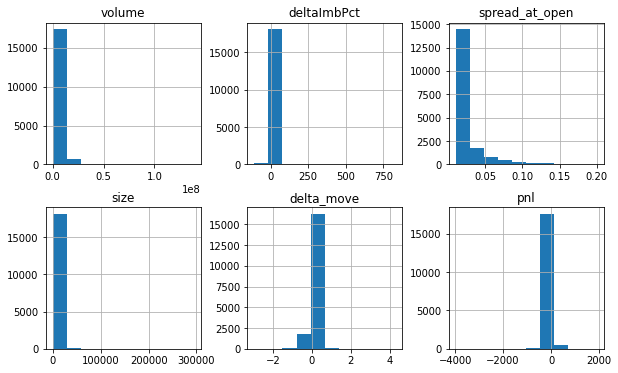

In [189]:
df.hist(column=['volume', 'deltaImbPct', 'spread_at_open', 'size', 'delta_move', 'pnl'], layout=(2,3), figsize=(10,6))

Now min `volume` is more than 100k. It is still far below our threshold at 2 mln. But let's leave it as it is until we can prove some reliable relationship between pnl and volume. 

At least there is `spread_at_open` column which is complementary and far more important and it distributes as expected with max spread at 20 cents. Let's check other important columns. 

The cheapest stock `open_price` was at 12 cents and the most expensive at 499 dollars. 

`deltaImbPct` has some tails but 25 and 75 percentiles are okay.

`deltaMove` which is a proxy of our pnl looks good, from -2.97 to 4.28 dollars. 

`size` and `position_size` are subjects for deeper investigation. Max values are equal to 1.3 mln and 300k shares respectively seems a "little bit" risky and may skew our `pnl` and `position_pnl` significantly. Before we dive deeper into this analysis, it is worth mentioning how I calculate these columns:
`position_size` is simply Bid/Aks size depending on direction of a position.
`size` is *min* value among two: `position_size` or bp (buying power, default 50k) divided by `open_price`. In this case price is proxy for volatility. The assumption is the more expensive stock the higher is volatility. It is true for most cases. But even with this limitation, it seems like we get some outliers that may skew the results as we can see that *mean* `delta_move` is positive and `pnl`s are highly negative. Meaning that **sizing is highly important!**

In [190]:
# Add absolute columns  
columns = ['deltaImbPct', 'imbBeforeReversePct', 'imbAfterReversePct', 'pnl', 'delta_move']
abs_columns = ['abs_' + str(col) for col in columns]
df[abs_columns] = df[columns].abs()

## Commissions <a class="anchor" id="third-bullet"></a> 

Fees = Comm + EcnFee + Sec + Clr + TicketFee

Comm = Shares * 0.0004

Ecn Remove = Shares * 0.00375

Ecn MOC = Shares * 0.001

SEC = Notional short * 0.0000221

Clr = 0.00032 * Shares

Ticket = 0.4$ for side (each symbol).

In [191]:
# Commissions
df['Comm'] = df['size'] * 0.0004
df['Ecn Remove entry'] = df['size'] * 0.00375
df['Ecn Remove exit'] = np.where(df['close_status'] == 'market', df['size'] * 0.00375, df['size'] * 0.001)
df['Ecn Fee'] = df['Ecn Remove entry'] + df['Ecn Remove exit']
df['Sec'] = np.where(df['direction'] == 'Short', df['size'] * 0.0000221, 0.0)
df['Clr'] = df['size'] * 0.00032
df['Ticket'] = 0.8
df['Fees'] = df['Comm'] + df['Ecn Fee'] + df['Sec'] + df['Clr'] + df['Ticket']
# Net Pnl
df['pnl_net'] = df['pnl'] - df['Fees']

First glance at results.

### Plot <a class="anchor" id="third-bullet-plot"></a> 

<AxesSubplot:>

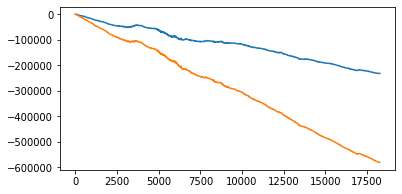

In [192]:
fig, ax = plt.subplots(1,1)
df['pnl'].cumsum().plot(ax=ax)
df['pnl_net'].cumsum().plot(ax=ax)

### Sharpe <a class="anchor" id="third-bullet-sharpe"></a> 

In [193]:
sharpe = df['pnl_net'].mean() / df['pnl_net'].std()
print('Sharpe with no filters is \n{}'.format(sharpe))

Sharpe with no filters is 
-0.2160198924247614


## Worst case scenario

In [194]:
k = 4

for i in range(1, k):
    df['spread_at_open_%d' % i] = df['spread_at_open'] * i
    df['delta_move_%d' % i] = df['delta_move'] - df['spread_at_open_%d' % i]
    df['pnl_net_%d' % i] = df['delta_move_%d' % i] * df['size']

## Price and position size analysis <a class="anchor" id="fourth-bullet"></a> 

Let's check relation between `size` and `pnl`. What I expect to see is obviously with the rise of size there is the rise of absolute pnl

r_sqr value: 0.3511742604267387
r_sqr value: 0.24838027935335294


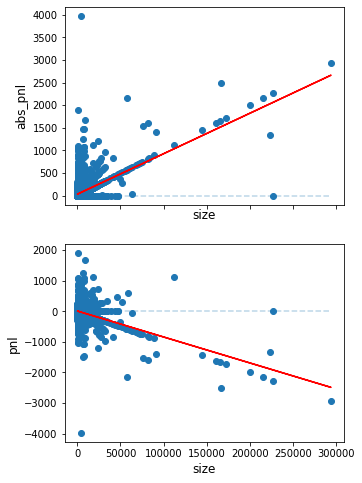

In [195]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,8))
plot_scatter(df, ax1, 'size', 'abs_pnl')
plot_scatter(df, ax2, 'size', 'pnl')

Wow! From the first scatter plot we realize that there is a relationship between size and pnl. But what is more interesting is that we get a bunch of losses where the `size` is more than 50k. This may be due to such *phenomenon as we trade cheap stocks around let's say 1 dollar price and we lose 1 or a few cents which lead to huge losses.* 

### Bins <a class="anchor" id="fourth-bullet-bins"></a> 

What I will do next is to confirm the hypothesis above. I want to find out if cheaper price leads to more negative pnl and vice versa. In other words, I want to see more clearly how the average pnl changes with the size. For that, I will use binning - define the arbitrary number of quantiles and let pandas figure out how to divide up the data. 

In [196]:
# Pnl and size bins
size_groups = 10
df['size_group'] = pd.qcut(df['size'], size_groups, labels=list(range(1, size_groups+1)))
df_size_group = pd.DataFrame()
df_size_group['count'] = df.groupby('size_group')['pnl'].count()
df_size_group['avg_pnl'] = df.groupby('size_group')['pnl'].mean()
df_size_group['sum_pnl'] = df.groupby('size_group')['pnl'].sum()
df_size_group['min_size'] = df.groupby('size_group')['size'].min()
df_size_group['max_size'] = df.groupby('size_group')['size'].max()
df_size_group['quantile10_size'] = df.groupby('size_group')['size'].quantile(0.1)
df_size_group['quantile90_size'] = df.groupby('size_group')['size'].quantile(0.9)
df_size_group['avg_size'] = df.groupby('size_group')['size'].mean()
df_size_group['min_price'] = df.groupby('size_group')['open_price'].min()
df_size_group['max_price'] = df.groupby('size_group')['open_price'].max()
df_size_group['quantile10_price'] = df.groupby('size_group')['open_price'].quantile(0.1)
df_size_group['quantile90_price'] = df.groupby('size_group')['open_price'].quantile(0.9)
df_size_group['avg_price'] = df.groupby('size_group')['open_price'].mean()
df_size_group

,count,avg_pnl,sum_pnl,min_size,max_size,quantile10_size,quantile90_size,avg_size,min_price,max_price,quantile10_price,quantile90_price,avg_price
size_group,,,,,,,,,,,,,
1,1836,2.849410,5231.516410,1.000000,150.000000,32.000000,121.000000,93.156293,0.46,499.18,33.425,214.990,112.622331
2,1813,4.899770,8883.283411,151.000000,273.044998,181.018761,248.000000,207.441631,0.25,327.02,33.914,227.380,117.919950
3,1833,2.408549,4414.870529,273.403325,402.000000,300.000000,400.000000,336.876953,0.17,182.88,26.078,154.706,82.797791
4,1816,1.610821,2925.251361,402.187902,629.643622,424.000000,601.000000,518.754637,0.17,124.32,21.600,104.040,63.947368
5,1826,1.720284,3141.238734,629.722922,945.358291,660.676544,903.179191,783.007922,0.28,79.40,19.800,71.465,47.912700
6,1847,-0.243757,-450.219398,946.073794,1400.000000,991.906084,1359.882513,1177.455615,0.49,52.85,17.882,48.662,35.388966
7,1800,-4.735213,-8523.383010,1400.168020,2146.844139,1454.300524,2061.855670,1742.983661,0.29,35.71,15.009,33.821,25.666978
8,1825,-8.970720,-16371.564818,2148.000000,3409.000000,2247.191011,3229.184496,2717.166388,0.34,23.27,11.512,21.896,17.199315
9,1824,-24.641359,-44945.838354,3410.641201,5688.282139,3572.194425,5307.855626,4430.249308,0.41,14.66,8.613,13.787,10.831113


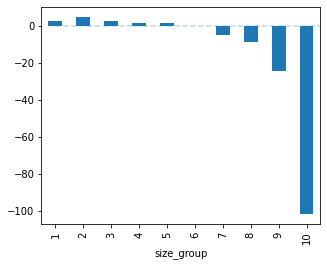

In [197]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df_size_group['avg_pnl'].plot.bar(ax=ax1)
ax1.hlines(0, 0, 10, linestyles='dashed', alpha=0.3)

There is an equal number of observations/positions in each bin. And that the higher size in cheaper stocks leads to highly negative results. So, let's define our threshold. The first 5 groups are positive on pnl. I will take 90% percentile of size as my upper threshold for volume and 10% percentile of price as my bottom threshold for price.
If we round these numbers we will get: **max_volume = 900** shares and **min_price = 20 dollars**.

In [198]:
# Filter
max_volume = 900 
min_price = 20 
df_filter_vp = df[(df['size'] <= max_volume) & (df['open_price'] >= min_price)].copy()

### Plot <a class="anchor" id="fourth-bullet-plot"></a> 

<AxesSubplot:>

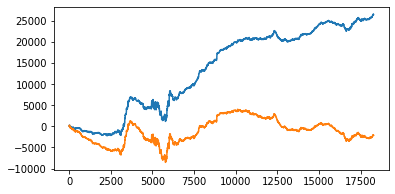

In [199]:
fig, ax = plt.subplots(1,1)
df_filter_vp['pnl'].cumsum().plot(ax=ax)
df_filter_vp['pnl_net'].cumsum().plot(ax=ax)

### Sharpe <a class="anchor" id="fourth-bullet-sharpe"></a> 

In [200]:
sharpe_vp = df_filter_vp['pnl_net'].mean() / df_filter_vp['pnl_net'].std()
print('Sharpe with next filters: max position size {} shares, min price ${} is \n{}'.format(max_volume, min_price, sharpe_vp))

Sharpe with next filters: max position size 900 shares, min price $20 is 
-0.003661818625342739


## Imbalance delta analysis <a class="anchor" id="fifth-bullet"></a> 

Let's apply same analysis to see if `abs_deltaImbPct`

### Bins <a class="anchor" id="fifth-bullet-bins"></a> 

In [201]:
# Pnl and size bins
imb_groups = 8
df_filter_vp['imb_group'] = pd.qcut(df['abs_deltaImbPct'], imb_groups, labels=list(range(1, imb_groups+1)))
df_imb_group = pd.DataFrame()
df_imb_group['count'] = df_filter_vp.groupby('imb_group')['pnl'].count()
df_imb_group['avg_pnl'] = df_filter_vp.groupby('imb_group')['pnl'].mean()
df_imb_group['sum_pnl'] = df_filter_vp.groupby('imb_group')['pnl'].sum()
df_imb_group['min_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].min()
df_imb_group['max_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].max()
df_imb_group['quantile10_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].quantile(0.1)
df_imb_group['quantile90_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].quantile(0.9)

df_imb_group

,count,avg_pnl,sum_pnl,min_size,max_size,quantile10_size,quantile90_size
imb_group,,,,,,,
1,1013,-3.511153,-3556.798394,1.000117,1.120132,1.011200,1.106296
2,1051,-1.009982,-1061.490835,1.120141,1.285394,1.132556,1.264776
3,1061,2.299233,2439.486064,1.285527,1.504693,1.306118,1.478695
4,1074,-0.404618,-434.560143,1.504736,1.812449,1.531954,1.775368
5,1017,1.565672,1592.288008,1.813165,2.283403,1.844145,2.232373
6,1072,1.964865,2106.334939,2.284114,3.064770,2.344119,2.947050
7,1049,9.369833,9828.954916,3.068791,4.912963,3.179064,4.641766
8,1006,15.469092,15561.906643,4.914437,155.659856,5.278106,17.625827


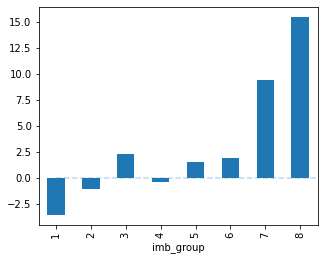

In [202]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df_imb_group['avg_pnl'].plot.bar(ax=ax1)
ax1.hlines(0, 0, 8, linestyles='dashed', alpha=0.3)

Awesome! Another clear confirmation of our hypothesis. With more significant reversal we get better and better pnl. From group 5 the pnl becomes consistently positive. From group 7 it becomes much better. So, we can take both into consideration. The last one can be more conservative one. Let's define our thresholds for `abs_deltaImbPct`: **min_deltaImbPct = 1.8** and **min_deltaImbPct_conservative = 3**

In [203]:
# Filter
min_deltaImbPct = 1.8
min_deltaImbPct_conservative = 3
df_filter_vpi = df_filter_vp[df_filter_vp['abs_deltaImbPct'] > min_deltaImbPct].copy()
df_filter_vpi_conservative = df_filter_vp[df_filter_vp['abs_deltaImbPct'] > min_deltaImbPct_conservative].copy()

### Plot <a class="anchor" id="fifth-bullet-plot"></a> 

<AxesSubplot:>

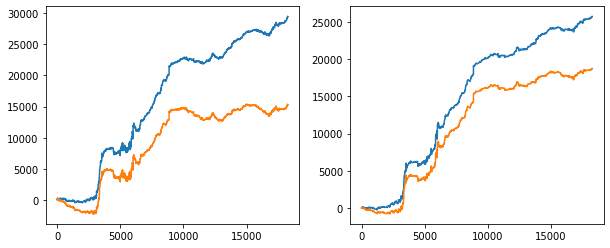

In [204]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
df_filter_vpi['pnl'].cumsum().plot(ax=ax1)
df_filter_vpi['pnl_net'].cumsum().plot(ax=ax1)
df_filter_vpi_conservative['pnl'].cumsum().plot(ax=ax2)
df_filter_vpi_conservative['pnl_net'].cumsum().plot(ax=ax2)

### Sharpe <a class="anchor" id="fifth-bullet-sharpe"></a> 

In [205]:
sharpe_vpi = df_filter_vpi['pnl_net'].mean() / df_filter_vpi['pnl_net'].std()
sharpe_vpi_conservative = df_filter_vpi_conservative['pnl_net'].mean() / df_filter_vpi_conservative['pnl_net'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}% is \n{}'.format(max_volume, min_price, min_deltaImbPct, sharpe_vpi))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}% is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, sharpe_vpi_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8% is 
0.05055202197478289
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3% is 
0.10586260204783368


## Close status analysis <a class="anchor" id="sixth-bullet"></a> 

There are two types of close statuses: moc and market. Moc is used when the position is entered later then 59th minute. As holding period is 1 min it means that there is no enough time to close on market. With moc order we don't pay spread. Consequently, we expect better avg pnl.   

In [206]:
df_close_status_group = pd.DataFrame() 
df_close_status_group['sum_pnl'] = df_filter_vpi.groupby('close_status')['pnl'].sum()
df_close_status_group['avg_pnl'] = df_filter_vpi.groupby('close_status')['pnl'].mean()
df_close_status_group['count'] = df_filter_vpi.groupby('close_status')['pnl'].count()
df_close_status_group

,sum_pnl,avg_pnl,count
close_status,,,
market,-2640.792222,-0.990545,2666
moc,32081.292112,21.147852,1517


As expected, trades after 15:59 are much more profitable. The same moment, trades "on market" are negative on average. Also, it is worht mentioning that number of trades with moc status are twice less than on market. It is important point when we take into consideration commissions.

In [207]:
# Filter
close_status = 'moc'
df_filter_vpis = df_filter_vpi[df_filter_vpi['close_status']==close_status].copy()
df_filter_vpis_conservative = df_filter_vpi_conservative[df_filter_vpi_conservative['close_status']==close_status].copy()

### Plot <a class="anchor" id="sixth-bullet-plot"></a> 

<AxesSubplot:>

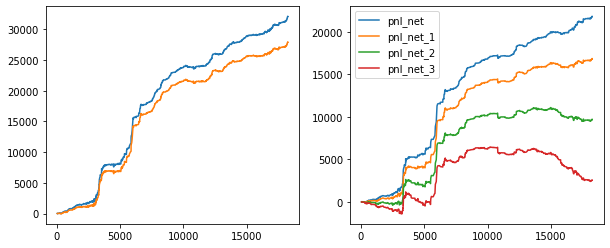

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
df_filter_vpis['pnl'].cumsum().plot(ax=ax1)
df_filter_vpis['pnl_net'].cumsum().plot(ax=ax1)
# df_filter_vpis_conservative['pnl'].cumsum().plot(ax=ax2)
df_filter_vpis_conservative[['pnl_net', 'pnl_net_1', 'pnl_net_2', 'pnl_net_3']].cumsum().plot(ax=ax2)

### Sharpe <a class="anchor" id="sixth-bullet-sharpe"></a> 

In [209]:
sharpe_vpis = df_filter_vpis['pnl_net'].mean() / df_filter_vpis['pnl_net'].std()
sharpe_vpis_conservative = df_filter_vpis_conservative['pnl_net'].mean() / df_filter_vpis_conservative['pnl_net'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {} is \n{}'.format(max_volume, min_price, min_deltaImbPct, close_status, sharpe_vpis))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {} is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, close_status, sharpe_vpis_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8%, close status moc is 
0.22201943178865058
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3%, close status moc is 
0.26822519621852564


## MAE/MFE <a class="anchor" id="seventh-bullet"></a> 

*Maximum Adverse Excursion (MAE)* - the MAE is the largest experienced loss during a trade; it measures how far price went against you.

*Maximum Favorable Excursion (MFE)* - the MFE is the opposite of the MAE and it measures the largest observed profit during a trade.

It is useful to understand the MAE and MFE of trades in order to inform the setting of stop and take profit levels. In reality, I find these metrics to be more useful from an academic perspective rather than a practical one, as often the placement of stops and take profit levels is dependent on volatility, and thus examination of MAE and MFE without considering volatility is of limited use. Still, visualizing these metrics can quickly alert you as to whether there is something drastically wrong with your strategy’s exit conditions. 

Timing columns:`start`, `stop`, `max_pnl_time`, `min_pnl_time`

Price column: `open_price`, `close_price`, `max_pnl_price`, `min_pnl_price`

In [210]:
# MAE
df_filter_vpi.loc[df_filter_vpi['direction'] == 'Long', 'delta_move_mae'] = df_filter_vpi['min_pnl_price'] - df_filter_vpi['open_price'] 
df_filter_vpi.loc[df_filter_vpi['direction'] == 'Short', 'delta_move_mae'] = df_filter_vpi['open_price'] - df_filter_vpi['min_pnl_price']
# MFE
df_filter_vpi.loc[df_filter_vpi['direction'] == 'Long', 'delta_move_mfe'] = df_filter_vpi['max_pnl_price'] - df_filter_vpi['open_price'] 
df_filter_vpi.loc[df_filter_vpi['direction'] == 'Short', 'delta_move_mfe'] = df_filter_vpi['open_price'] - df_filter_vpi['max_pnl_price']

### Plot <a class="anchor" id="seventh-bullet-plot"></a> 

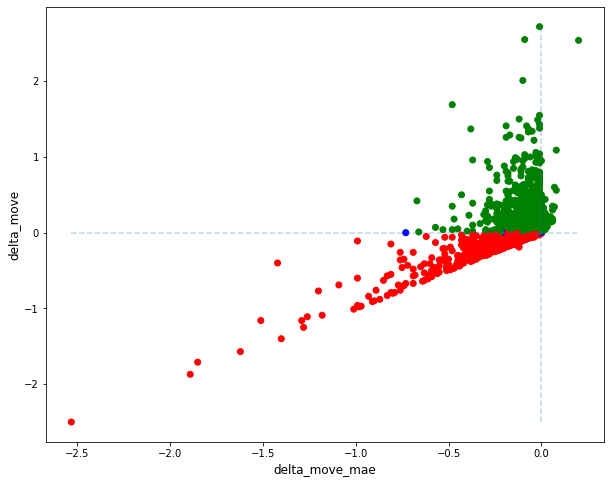

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'delta_move_mae'
ycolumn = 'delta_move'
col = np.where(df_filter_vpi[ycolumn].values < 0,'r',np.where(df_filter_vpi[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vpi[xcolumn].values, df_filter_vpi[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vpi[xcolumn].min(), df_filter_vpi[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vpi[ycolumn].min(), df_filter_vpi[ycolumn].max(), linestyles='dashed', alpha=0.3)

On the horizontal axis, we have the trade MAE in pct. On the vertical axis, we have the trade final profit in pct. Red dots denote losing trades; green dots denote winning trades. We can see that all the trades that lie above zero on the vertical axis are thus represented as green dots, and those lying below zero as red dots.  Notice that there is a diagonally downwards sloping invisible line that appears to act as a hard limit – there are no red dots below this line. Of course, dots that lie along this line represent trades whose MAE is equal to their final result – that is, they were closed at the worst possible time. 

...

That means that we could make our stop loss slightly wider than this MAE and not stop out any winning trades at all, however, all the losing trades that lost more than X pct would be limited to losing only X pct (plus slippage). 

The same but in pnl measures. The assumption we make here is that our pnl already incorporates volatility. We could suggest stop loss on pnl as a function of bp (buying power). 

In [212]:
df_filter_vpi['pnl_mae'] = df_filter_vpi['delta_move_mae'] * df_filter_vpi['size']
df_filter_vpi['pnl_mfe'] = df_filter_vpi['delta_move_mfe'] * df_filter_vpi['size']

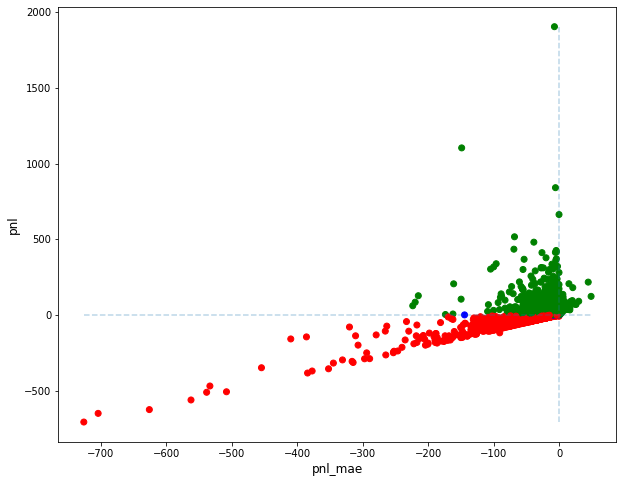

In [213]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'pnl_mae'
ycolumn = 'pnl'
col = np.where(df_filter_vpi[ycolumn].values < 0,'r',np.where(df_filter_vpi[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vpi[xcolumn].values, df_filter_vpi[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vpi[xcolumn].min(), df_filter_vpi[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vpi[ycolumn].min(), df_filter_vpi[ycolumn].max(), linestyles='dashed', alpha=0.3)

As we have seen on previous ananlysis of close status the **market trades** are negative on average. Let's focus on this part to see if we can make it better with the help of MAE/MFE analysis.

In [214]:
df_filter_vpi_market = df_filter_vpi[df_filter_vpi['close_status']=='market'].copy()
print('Count: {}\nMean: {}\nSum: {}\nSharpe: {}'.format(df_filter_vpi_market['pnl_net'].count(), df_filter_vpi_market['pnl_net'].mean(), df_filter_vpi_market['pnl_net'].sum(), df_filter_vpi_market['pnl_net'].mean()/df_filter_vpi_market['pnl_net'].std()))

Count: 2666
Mean: -4.728062741430764
Sum: -12605.015268654417
Sharpe: -0.07365988791235807


Plot MAE for this dataframe

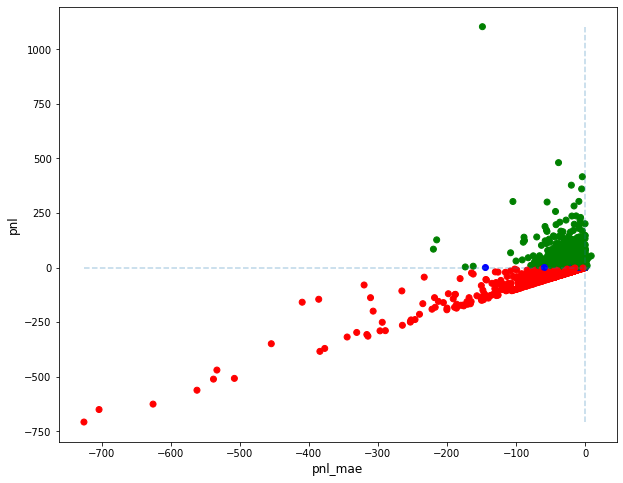

In [215]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'pnl_mae'
ycolumn = 'pnl'
col = np.where(df_filter_vpi_market[ycolumn].values < 0,'r',np.where(df_filter_vpi_market[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vpi_market[xcolumn].values, df_filter_vpi_market[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vpi_market[xcolumn].min(), df_filter_vpi_market[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vpi_market[ycolumn].min(), df_filter_vpi_market[ycolumn].max(), linestyles='dashed', alpha=0.3)

### Stop loss <a class="anchor" id="seventh-bullet-sl"></a> 

Definitely, we have some big losses. Let's imagine that we are going to implement *stop loss*. Green dot that lies the most to the left is trade with the biggest drawdown which is around -200 dollars. This will be our first stop loss.    

In [216]:
stop_loss = -250
colname = 'pnl_stop{}'.format(stop_loss)
df_filter_vpi_market[colname] = np.where(df_filter_vpi_market['pnl_mae'] < stop_loss, stop_loss, df_filter_vpi_market['pnl'])

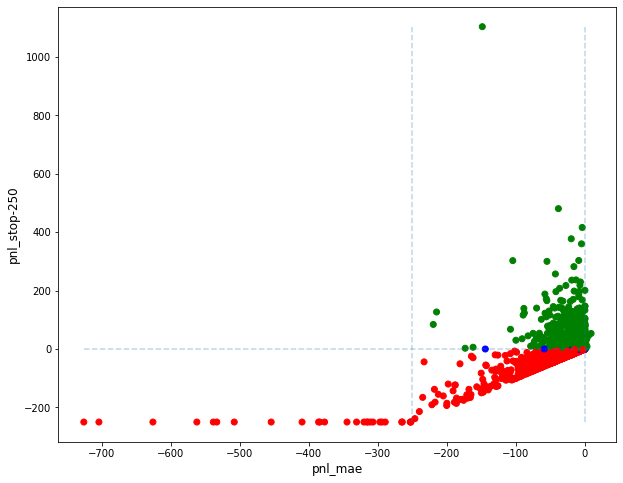

In [217]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'pnl_mae'
ycolumn = colname
col = np.where(df_filter_vpi_market[ycolumn].values < 0,'r',np.where(df_filter_vpi_market[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vpi_market[xcolumn].values, df_filter_vpi_market[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vpi_market[xcolumn].min(), df_filter_vpi_market[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vpi_market[ycolumn].min(), df_filter_vpi_market[ycolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(stop_loss, df_filter_vpi_market[ycolumn].min(), df_filter_vpi_market[ycolumn].max(), linestyles='dashed', alpha=0.3)

All our green dots remained green. We just limited losses to 250 dollars. Check sharpe

In [218]:
print('Count: {}\nMean: {}\nSum: {}\nSharpe: {}'.format(df_filter_vpi_market[colname].count(), df_filter_vpi_market[colname].mean(), df_filter_vpi_market[colname].sum(), df_filter_vpi_market[colname].mean()/df_filter_vpi_market[colname].std()))

Count: 2666
Mean: -0.1339653145300892
Sum: -357.1515285372178
Sharpe: -0.0023209304292363684


Now we are at break even. Let's see what happens if we sacrifice some profitable trades in the sake of cutting more losses. New stop loss -120 dollars.

In [219]:
stop_loss = -100
colname = 'pnl_stop{}'.format(stop_loss)
df_filter_vpi_market[colname] = np.where(df_filter_vpi_market['pnl_mae'] < stop_loss, stop_loss, df_filter_vpi_market['pnl'])

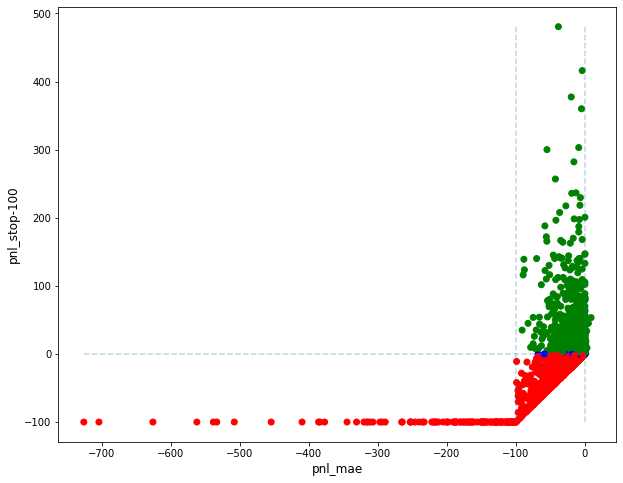

In [220]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'pnl_mae'
ycolumn = colname
col = np.where(df_filter_vpi_market[ycolumn].values < 0,'r',np.where(df_filter_vpi_market[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vpi_market[xcolumn].values, df_filter_vpi_market[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vpi_market[xcolumn].min(), df_filter_vpi_market[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vpi_market[ycolumn].min(), df_filter_vpi_market[ycolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(stop_loss, df_filter_vpi_market[ycolumn].min(), df_filter_vpi_market[ycolumn].max(), linestyles='dashed', alpha=0.3)

In [221]:
print('Count: {}\nMean: {}\nSum: {}\nSharpe: {}'.format(df_filter_vpi_market[colname].count(), df_filter_vpi_market[colname].mean(), df_filter_vpi_market[colname].sum(), df_filter_vpi_market[colname].mean()/df_filter_vpi_market[colname].std()))

Count: 2666
Mean: 0.7222411762551294
Sum: 1925.494975896175
Sharpe: 0.01545414186322576


Again, much better results. But for the moment I will leave it as it is because I don't want to overoptimize. After all, **risk management is important but it doesn't give us an edge**. 

At this stage of analysis I want to classify my trades according to ...

In [222]:
df_filter_vpi_market['delta_time_max_min'] = (pd.to_datetime(df_filter_vpi_market['max_pnl_time']) - pd.to_datetime(df_filter_vpi_market['min_pnl_time'])).dt.total_seconds() 
df_filter_vpi_market['delta_time_max_open'] = (pd.to_datetime(df_filter_vpi_market['max_pnl_time']) - pd.to_datetime(df_filter_vpi_market['start'])).dt.total_seconds() 
df_filter_vpi_market['delta_time_min_open'] = (pd.to_datetime(df_filter_vpi_market['min_pnl_time']) - pd.to_datetime(df_filter_vpi_market['start'])).dt.total_seconds() 
df_filter_vpi_market['delta_time_close_open'] = (pd.to_datetime(df_filter_vpi_market['stop']) - pd.to_datetime(df_filter_vpi_market['start'])).dt.total_seconds() 

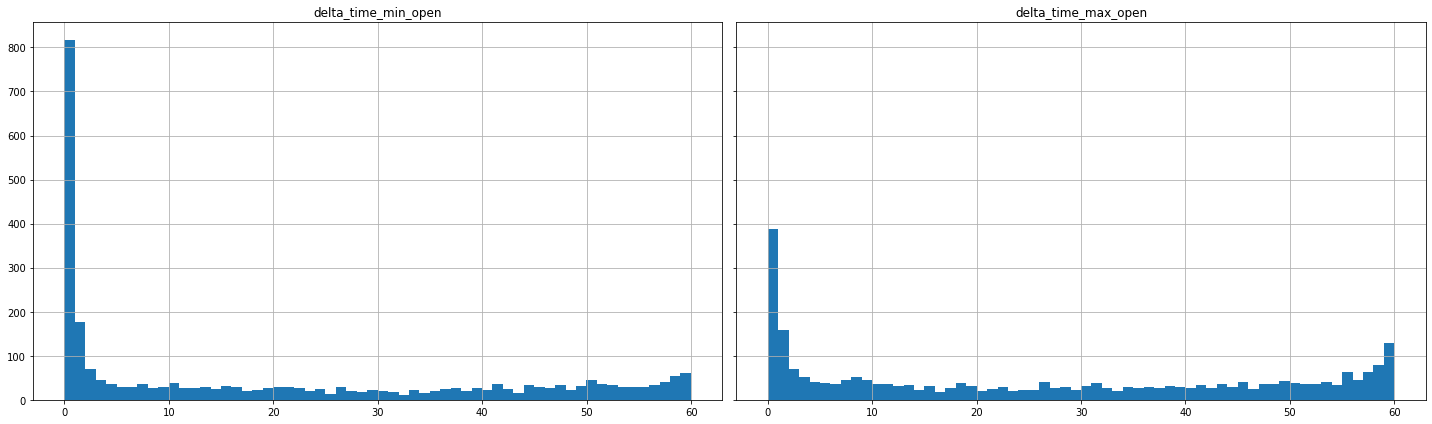

In [223]:
df_filter_vpi_market[['delta_time_min_open', 'delta_time_max_open']].hist(layout=(1,2),bins=60, figsize=(20,6), sharey=True)
plt.tight_layout()

In [224]:
df_filter_vpi_market['delta_time_min_open_group'] = pd.cut(df_filter_vpi_market['delta_time_min_open'], 12, labels=list(range(1, 13)))
df_filter_vpi_market['delta_time_max_open_group'] = pd.cut(df_filter_vpi_market['delta_time_max_open'], 12, labels=list(range(1, 13)))

df_delta_time_group = pd.DataFrame()
df_delta_time_group['count_mae'] = df_filter_vpi_market.groupby('delta_time_min_open_group')['pnl_mae'].count()
df_delta_time_group['mean_mae'] = df_filter_vpi_market.groupby('delta_time_min_open_group')['pnl_mae'].mean()
df_delta_time_group['sum_mae'] = df_filter_vpi_market.groupby('delta_time_min_open_group')['pnl_mae'].sum()
df_delta_time_group['count_mfe'] = df_filter_vpi_market.groupby('delta_time_max_open_group')['pnl_mfe'].count()
df_delta_time_group['mean_mfe'] = df_filter_vpi_market.groupby('delta_time_max_open_group')['pnl_mfe'].mean()
df_delta_time_group['sum_mfe'] = df_filter_vpi_market.groupby('delta_time_max_open_group')['pnl_mfe'].sum()
df_delta_time_group

,count_mae,mean_mae,sum_mae,count_mfe,mean_mfe,sum_mfe
delta_time_min_open_group,,,,,,
1,1145,-12.835461,-14696.603162,707,2.302447,1627.830025
2,148,-27.184042,-4023.238150,216,12.474460,2694.483357
3,144,-30.228244,-4352.867196,158,17.890728,2826.735061
4,129,-29.319530,-3782.219422,145,25.580753,3709.209250
5,127,-34.408226,-4369.844695,117,29.650211,3469.074663
6,103,-35.436335,-3649.942554,143,26.465234,3784.528413
7,87,-40.513778,-3524.698725,142,33.756878,4793.476739
8,121,-38.252471,-4628.548943,144,28.923936,4165.046820
9,130,-47.928853,-6230.750877,150,36.068400,5410.260075


I see nothing that I can make better with this peace of analysis.

## MOC print imapct <a class="anchor" id="eighth-bullet"></a> 

First, let's calculate hypothetical pnl in case we wanted to close position just the moment before market close.

In [225]:
df_filter_vpis['delta_move_no_moc'] = np.where(df_filter_vpis['direction']=='Long', df_filter_vpis['close_price'] - df_filter_vpis['open_price'], df_filter_vpis['open_price'] - df_filter_vpis['close_price'])
df_filter_vpis['pnl_no_moc'] = df_filter_vpis['delta_move_no_moc'] * df_filter_vpis['size']
df_filter_vpis.loc[df_filter_vpis['direction'] == 'Long', 'delta_move_mfe'] = df_filter_vpis['max_pnl_price'] - df_filter_vpis['open_price'] 
df_filter_vpis.loc[df_filter_vpis['direction'] == 'Short', 'delta_move_mfe'] = df_filter_vpis['open_price'] - df_filter_vpis['max_pnl_price']
df_filter_vpis['pnl_mfe'] = df_filter_vpis['delta_move_mfe'] * df_filter_vpis['size']
df_filter_vpis['delta_pnl'] = df_filter_vpis['pnl'] - df_filter_vpis['pnl_no_moc']
print('Sum Pnl with moc: {}\nSum Pnl no moc: {}\nSum Pnl max: {}'.format(df_filter_vpis['pnl'].sum(), df_filter_vpis['pnl_no_moc'].sum(), df_filter_vpis['pnl_mfe'].sum()))
# print(df_filter_vpis.loc[df_filter_vpis['pnl'] > df_filter_vpis['pnl_mfe'],['imbBeforeReversePct', 'imbAfterReversePct']].abs().quantile(0.9))
# print(df_filter_vpis.loc[df_filter_vpis['pnl'] > df_filter_vpis['pnl_no_moc'],['imbBeforeReversePct', 'imbAfterReversePct']].abs().quantile(0.9))
# print(df_filter_vpis.loc[:,['imbBeforeReversePct', 'imbAfterReversePct']].abs().quantile(0.9))

Sum Pnl with moc: 32081.292111847306
Sum Pnl no moc: 17831.16661929409
Sum Pnl max: 65186.86915583599


## Seasonality analysis <a class="anchor" id="nineth-bullet"></a> 

And as a lst part of analysis I want to do seasonality analysis. What I mean is usually on Friday the moc trading is more active due to final trading day of the week and some triple and quadruple witchings. I expect to see higher pnl on average on Fridays.  

In [226]:
df_filter_vpis['timeindex'] = pd.to_datetime(df_filter_vpis['date'])
df_filter_vpis['day_name'] = df_filter_vpis['timeindex'].map(lambda row: row.strftime("%A"))

df_filter_vpis_conservative['timeindex'] = pd.to_datetime(df_filter_vpis_conservative['date'])
df_filter_vpis_conservative['day_name'] = df_filter_vpis_conservative['timeindex'].map(lambda row: row.strftime("%A"))

In [227]:
df_day_group = pd.DataFrame()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_day_group['count'] = df_filter_vpis.groupby('day_name')['pnl'].count().reindex(day_names)
df_day_group['avg_pnl'] = df_filter_vpis.groupby('day_name')['pnl'].mean().reindex(day_names)
df_day_group['sum_pnl'] = df_filter_vpis.groupby('day_name')['pnl'].sum().reindex(day_names)
df_day_group

,count,avg_pnl,sum_pnl
day_name,,,
Monday,364,17.653982,6426.049552
Tuesday,269,31.149712,8379.272443
Wednesday,244,16.187688,3949.795928
Thursday,264,13.570369,3582.577352
Friday,376,25.913821,9743.596838


### Bins <a class="anchor" id="nineth-bullet-bins"></a> 

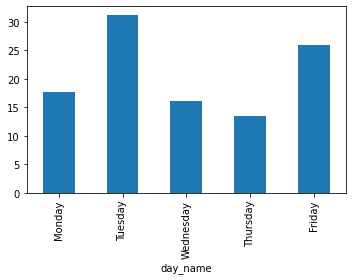

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
df_day_group['avg_pnl'].plot.bar(ax=ax)
fig.tight_layout()

And again we got the confirmation of hypothesis. Friday seems to be the most active due to number of trades and most profitable day by a wide margin.

In [229]:
# Filter
day_filter = 'Friday'
df_filter_vpisd = df_filter_vpis[df_filter_vpis['day_name']==day_filter].copy()
df_filter_vpisd_conservative = df_filter_vpis_conservative[df_filter_vpis_conservative['day_name']==day_filter].copy()

### Plot <a class="anchor" id="nineth-bullet-plot"></a> 

<AxesSubplot:>

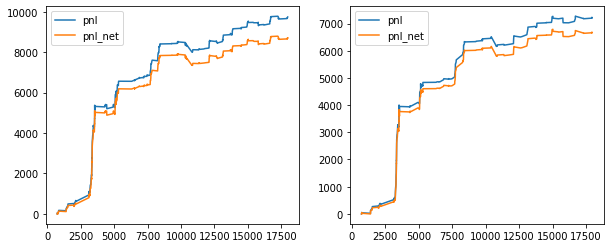

In [230]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
df_filter_vpisd[['pnl', 'pnl_net']].cumsum().plot(ax=ax1)
df_filter_vpisd_conservative[['pnl', 'pnl_net']].cumsum().plot(ax=ax2)

### Sharpe <a class="anchor" id="nineth-bullet-sharpe"></a> 

In [231]:
sharpe_vpisd = df_filter_vpisd['pnl_net'].mean()/df_filter_vpisd['pnl_net'].std()
sharpe_vpisd_conservative = df_filter_vpisd_conservative['pnl_net'].mean()/df_filter_vpisd_conservative['pnl_net'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {}, day {} is \n{}'.format(max_volume, min_price, min_deltaImbPct, close_status, day_filter, sharpe_vpisd))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {}, day {} is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, close_status, day_filter, sharpe_vpisd_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8%, close status moc, day Friday is 
0.2995093117858986
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3%, close status moc, day Friday is 
0.36592323782911823


And this is another significant improvement of sharpe.

## Finally <a class="anchor" id="tenth-bullet"></a> 

In [232]:
df_resample = pd.DataFrame()
# Copy
df_filter_vpis_copy = df_filter_vpis.copy()
# Add columns
df_filter_vpis_copy.loc[df_filter_vpis_copy['direction'] == 'Long', 'delta_move_mae'] = df_filter_vpis_copy['min_pnl_price'] - df_filter_vpis_copy['open_price'] 
df_filter_vpis_copy.loc[df_filter_vpis_copy['direction'] == 'Short', 'delta_move_mae'] = df_filter_vpis_copy['open_price'] - df_filter_vpis_copy['min_pnl_price']
# Timeindex
df_filter_vpis_copy.set_index('timeindex', inplace=True)
# Pnl
df_resample['GrossPnl'] = df_filter_vpis_copy['pnl'].resample('B').sum()
df_resample['NetPnl'] = df_filter_vpis_copy['pnl_net'].resample('B').sum()
df_resample['CumGrossPnl'] = df_resample['GrossPnl'].cumsum().fillna(0)
df_resample['CumNetPnl'] = df_resample['NetPnl'].cumsum().fillna(0)
# Volume
df_resample['Volume'] = df_filter_vpis_copy['size'].resample('B').sum()
df_resample['Turnover'] = df_resample['Volume'] * 2
# Hold
df_filter_vpis_copy['delta_time_close_open'] = (pd.to_datetime(df_filter_vpis_copy['stop']) - pd.to_datetime(df_filter_vpis_copy['start'])).dt.total_seconds() 
df_resample['AvgHold'] = df_filter_vpis_copy['delta_time_close_open'].resample('B').mean()
# Symbols
TradedSymbols = len(df_filter_vpis_copy['symbol'].unique())
# MAE
df_filter_vpis_copy['pnl_mae'] = df_filter_vpis_copy['delta_move_mae'] * df_filter_vpis_copy['size']
df_resample['MinMAE'] = df_filter_vpis_copy['pnl_mae'].resample('B').min()
# Filter zero volume days - no trading
df_resample = df_resample[df_resample['Volume'] > 0]
# Drawdown
df_resample['RollMax'] = df_resample['CumNetPnl'].cummax()
df_resample['Drawdown'] = df_resample['CumNetPnl'] - df_resample['RollMax'] #/ df_resample['RollMax']

In [233]:
df_filter_vpis_copy[['stop', 'start', 'delta_time_close_open']].head()

,stop,start,delta_time_close_open
timeindex,,,
2020-02-03,2020-02-03 16:00:00,2020-02-03 15:59:16,44.0
2020-02-03,2020-02-03 16:00:00,2020-02-03 15:59:08,52.0
2020-02-03,2020-02-03 16:00:00,2020-02-03 15:59:17,43.0
2020-02-03,2020-02-03 16:00:00,2020-02-03 15:59:17,43.0
2020-02-03,2020-02-03 16:00:00,2020-02-03 15:59:17,43.0


In [234]:
df_stats = pd.DataFrame()
df_filter_vpis_copy.loc[df_filter_vpis_copy['pnl']<0, 'WinLoss'] = 'Loss'
df_filter_vpis_copy.loc[df_filter_vpis_copy['pnl']>0, 'WinLoss'] = 'Win'
df_filter_vpis_copy.loc[df_filter_vpis_copy['pnl']==0, 'WinLoss'] = 'Flat'
df_stats['count'] = df_filter_vpis_copy.groupby('WinLoss')['pnl'].count()
df_stats['avg'] = df_filter_vpis_copy.groupby('WinLoss')['pnl'].mean()

### Ratios <a class="anchor" id="tenth-bullet-ratios"></a> 

In [235]:
PnL = round(df_resample['NetPnl'].sum(), 0)
PPS = round(df_resample['GrossPnl'].sum() / df_resample['Volume'].sum(), 5)
Turnover = df_resample['Turnover'].sum()
AvgWin = round(df_stats.loc['Win', 'avg'], 2)
AvgLoss = round(df_stats.loc['Loss', 'avg'], 2)
TotalTrades = df_stats.loc[:, 'count'].sum()
AvgWinPct = round(df_stats.loc['Win', 'count'] * 100 / TotalTrades, 2)
AvgLossPct = round(df_stats.loc['Loss', 'count'] * 100  / TotalTrades, 2)
AvgWinLossRatio = round(abs(AvgWin / AvgLoss), 2)
TradedDays = len(df_resample[df_resample['Volume'] > 0])
AvgHold = round(df_resample['AvgHold'].mean(), 2)
Sharpe = round(np.sqrt(252) * df_resample['NetPnl'].mean() / df_resample['NetPnl'].std(), 2)
MaxDD = round(df_resample['Drawdown'].min(), 2)
MeanDD = round(df_resample['Drawdown'].mean(), 2)
MaxDDPct = round(MaxDD * 100 / PnL, 2)
MeanDDPct =round( MeanDD * 100 / PnL, 2)
BestDay = round(df_resample['NetPnl'].max(), 0)
WorstDay = round(df_resample['NetPnl'].min(), 0)
ProfitableDaysPct = round(len(df_resample[df_resample['NetPnl'] > 0]) * 100 / len(df_resample), 2)
WorstTradeMAE = round(df_resample['MinMAE'].min(), 2)

In [236]:
ratios = []
ratios.append({'PnL': PnL, 
               'PPS': PPS, 
               'Turnover': Turnover, 
               'TradedSymbols': TradedSymbols, 
               'AvgWin': AvgWin, 
               'AvgLoss': AvgLoss, 
               'AvgWin%': AvgWinPct, 
               'AvgLoss%': AvgLossPct, 
               'WinToLossRatio': AvgWinLossRatio, 
               'TradedDays': TradedDays, 
               'AvgHold': AvgHold, 
               'BestDay': BestDay, 
               'WorstDay': WorstDay, 
               'ProfitableDays%': ProfitableDaysPct, 
               'Sharpe': Sharpe, 
               'MaxDD': MaxDD, 
               'MeanDD': MeanDD, 
               'MaxDD%': MaxDDPct, 
               'MeanDD%': MeanDDPct, 
               'WorstTradeMAE': WorstTradeMAE})

df_ratios = pd.DataFrame(ratios)
df_ratios

,PnL,PPS,Turnover,TradedSymbols,AvgWin,AvgLoss,AvgWin%,AvgLoss%,WinToLossRatio,TradedDays,AvgHold,BestDay,WorstDay,ProfitableDays%,Sharpe,MaxDD,MeanDD,MaxDD%,MeanDD%,WorstTradeMAE
0,27910.0,0.05945,1.079306e+06,388,48.09,-27.4,62.76,32.96,1.76,162,39.99,4927.0,-261.0,75.93,4.92,-461.87,-48.9,-1.65,-0.18,-351.97


### Plot <a class="anchor" id="tenth-bullet-plot"></a> 

<AxesSubplot:xlabel='timeindex'>

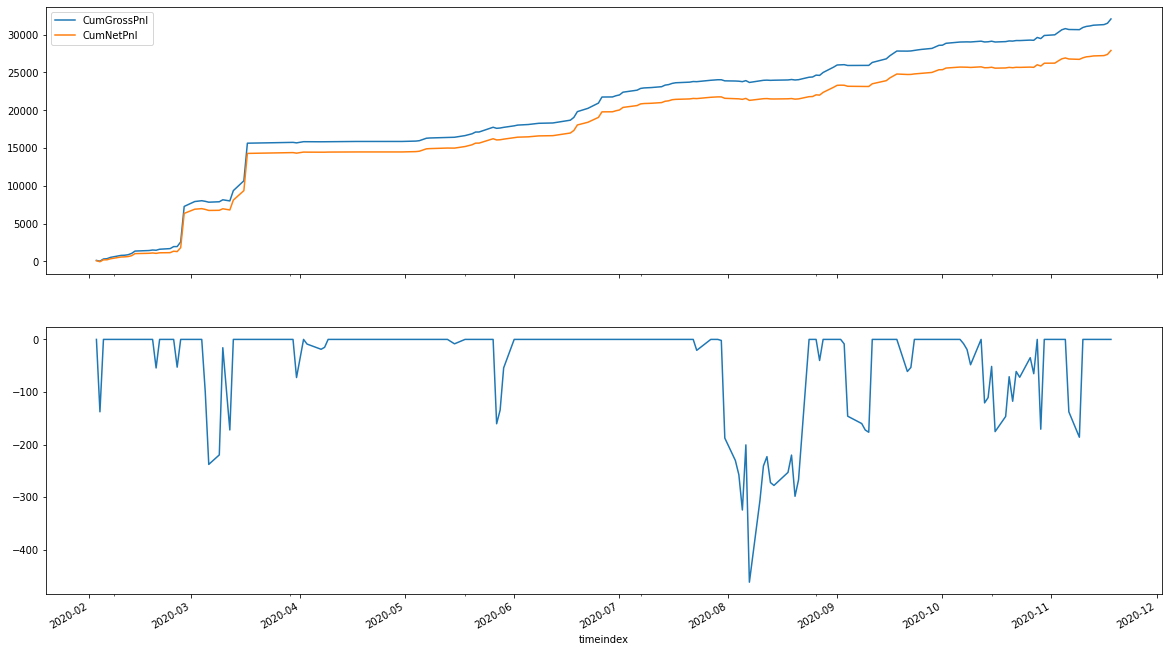

In [237]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 12))
df_resample[['CumGrossPnl', 'CumNetPnl']].plot(ax=ax1)
df_resample['Drawdown'].plot(ax=ax2)

## Table of contents:
* [Libraries, functions, constants](#first-bullet)
* [Peak at data](#second-bullet)
* [Commissions](#third-bullet)
    * [Plot](#third-bullet-plot)
    * [Sharpe](#third-bullet-sharpe)
* [Price and position size analysis](#fourth-bullet)
    * [Bins](#fourth-bullet-bins)
    * [Plot](#fourth-bullet-plot)
    * [Sharpe](#fourth-bullet-sharpe)
* [Imbalance delta analysis](#fifth-bullet)
    * [Bins](#fifth-bullet-bins)
    * [Plot](#fifth-bullet-plot)
    * [Sharpe](#fifth-bullet-sharpe)
* [Close status analysis](#sixth-bullet)
    * [Plot](#sixth-bullet-plot)
    * [Sharpe](#sixth-bullet-sharpe)
* [MAE/MFE](#seventh-bullet)
    * [Plot](#seventh-bullet-plot)
    * [Stop loss](#seventh-bullet-sl)
* [MOC print imapct ](#eigth-bullet)
* [Seasonality analysis](#nineth-bullet)
    * [Bins](#nineth-bullet-bins)
    * [Plot](#nineth-bullet-plot)
    * [Sharpe](#nineth-bullet-sharpe)
* [Finally](#tenth-bullet)
    * [Ratios](#tenth-bullet-ratios)
    * [Plot](#tenth-bullet-plot)